In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D

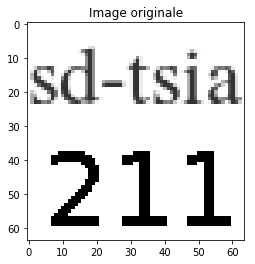

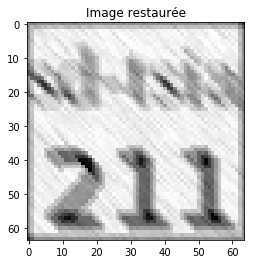

In [2]:
data=pickle.load(open('data2018.pk','rb'))
original=data.get('original')
filtre=data.get('filtre')
H=data.get('H')
observations=data.get('observations')
T=data.get('T')

plt.imshow(original,cmap='gray')
plt.title("Image originale")
plt.show()

plt.imshow(observations,cmap='gray')
plt.title("Image restaurée")
plt.show()

## 2.2 Algorithme ADMM

### Préparation 1

$$f(x)=\frac{1}{2}{||y-Hx||_2}^2$$
$$g(z)=\beta ||z_2||_1+l_{[0,1]^p}(z_1)$$
$$z=\begin{bmatrix}x\\Tx\end{bmatrix}$$
$$A=\begin{bmatrix}Id_p\\T\end{bmatrix}$$

### Préparation 2

$L_\rho=\frac{1}{2}||y-Hx||^2_2+\beta||z_2||_1+l_{[0,1]^p}(z_1)+\gamma_1^T(x-z_1)+\frac{\rho}{2}||x-z_1||_2^2+\gamma_2^T(Tx-z_2)+\frac{\rho}{2}||Tx-z_2||^2_2$

### Préparation 3

Il faut que $\frac{\partial L_\rho}{\partial x}=0$<br>
$\frac{\partial L_\rho}{\partial x}=-H^T(y-Hx)+\gamma_1+\rho(x-z_1)+T^T\gamma_2+\rho T^T(Tx-z_2)=0$<br>
donc $x=(H^TH+\rho Id_p+\rho T^TT)^{-1}(H^Ty-\gamma_1+\rho z_1-T^T \gamma_2+\rho T^Tz_2)$

### Préparation 4

Pour $z_1$, on cherche à trouver<br> 
$z_1=argmin_z l_{[0,1]^p}(z)+\gamma_1^T(x-z)+\frac{\rho}{2}||x-z||_2^2$<br>
$=argmin_z l_{[0,1]^p}(z)+\frac{\rho}{2}||z-x-\frac{\gamma_1}{\rho}||_2^2-\frac{\rho}{2}||\frac{\gamma_1}{\rho}||^2_2$<br>
$=argmin_z l_{[0,1]^p}(z)+\frac{\rho}{2}||z-x-\frac{\gamma_1}{\rho}||_2^2$<br>
$=argmin_{z \in [0,1]^p} ||z-(x+\frac{\gamma_1}{\rho})||_2^2$<br>
On observe que z est la projection de $x+\frac{\gamma_1}{\rho}$ sur $[0,1]^p$

Pour $z_2$, on cherche àtrouver<br>
$z_2=argmin_z \beta||z||_1+\gamma_2^T(Tx-z)+\frac{\rho}{2}||Tx-z||^2_2$<br>
$=argmin_z \beta||z||_1+\frac{\rho}{2}||z-Tx-\frac{\gamma_2}{\rho}||_2^2$<br>
$=prox_{\frac{\beta}{\rho}||\cdot ||_1}(Tx+\frac{\gamma_2}{\rho})$<br>
$z_{2,i}=\begin{cases}
 Tx_i+\frac{\gamma_{2,i}}{\rho}-\frac{\beta}{\rho}& \text{ if } Tx_i+\frac{\gamma_{2,i}}{\rho} \geq \frac{\beta}{\rho}\\ 
 Tx_i+\frac{\gamma_{2,i}}{\rho}+\frac{\beta}{\rho}& \text{ if } Tx_i+\frac{\gamma_{2,i}}{\rho} \leq -\frac{\beta}{\rho}\\ 
 0 & \text{ if } Tx_i+\frac{\gamma_{2,i}}{\rho} \in [-\frac{\beta}{\rho},\frac{\beta}{\rho}]
\end{cases}$

### Préparation 5

$\begin{bmatrix}\gamma_{1,k+1}\\ \gamma_{2,k+1}\end{bmatrix}=\begin{bmatrix}\gamma_{1,k}\\ \gamma_{2,k}\end{bmatrix}+\rho(Ax^{k+1}-z^{k+1})$<br>
$\gamma_{1,k+1} =\gamma_{1,k+1} + \rho(x^{k+1} - z_1^{k+1})$<br>
$\gamma_{2,k+1} =\gamma_{2,k+1} + \rho(Tx^{k+1} - z_2^{k+1})$

## 3 Implémentation de l'ADMM pour résoudre le problème de restauration d'image

In [3]:
rho=0.01
beta=0.01
k_max=100

### Manipulation 2

In [26]:
def ADMM(x,y,y0,z1,z2,H,T,gamma1,gamma2,rho,beta,max_iter=k_max,stop=1e-3):
    n,p=T.shape
    j=0
    EQM=[]
    L=[]
    Iter=0
    for j in range(max_iter):
        

        #x
        A=H.T.dot(H)+rho*np.eye(p)+rho*T.T.dot(T)
        b=H.T.dot(y)-gamma1+rho*z1-T.T.dot(gamma2)+rho*T.T.dot(z2)
        tmp=linalg.cg(A,b)[0]
        #arrêter  si x varie très peu 
        if(np.sum((x-tmp)**2)<stop):
            break
        else:
            x=tmp
        
        #z1
        for i in range(p):
            t=x[i]+gamma1[i]/rho
            if(t>1):
                z1[i]=1
            elif(t<0):
                z1[i]=0
            else:
                z1[i]=t
                
        #z2
        tmp=T.dot(x)
        for i in range(n):
            t=tmp[i]+gamma2[i]/rho
            alpha=beta/rho
            if(t>alpha):
                z2[i]=t-alpha
            elif(t<-alpha):
                z2[i]=t+alpha
            else:
                z2[i]=0
                
        #gamma
        gamma1=gamma1+rho*(x-z1)
        gamma2=gamma2+rho*(T.dot(x)-z2)
        
        #EQM
        EQM.append(1/p*np.sum((x-y0)**2))
        
        #Lagrangian
        l=0.5*np.sum((y-H.dot(x))**2)+beta*np.sum(np.fabs(z2))+gamma1.dot(x-z1) \
        +0.5*rho*np.sum((x-z1)**2)+gamma2.dot(T.dot(x)-z2)+0.5*rho*np.sum((T.dot(x)-z2)**2)
        L.append(l)
        
        Iter=Iter+1
        
    return x,EQM,L,Iter

In [27]:
y0=np.ravel(original)
y=np.ravel(observations)
n,p=T.shape

In [28]:
t0=time.time()
x=np.zeros_like(y)
z1 = x
z2 = T.dot(x)
gamma1 = np.zeros_like(z1)
gamma2 = np.zeros_like(z2)
x_,EQM,L,Iter=ADMM(x,y,y0,z1,z2,H,T,gamma1,gamma2,rho,beta,max_iter=k_max)
print("temps: %f" %(time.time()-t0))
print("nombre d\'itération: %f" %Iter)

temps: 32.300793
nombre d'itération: 42.000000


Le résultat obtenu:

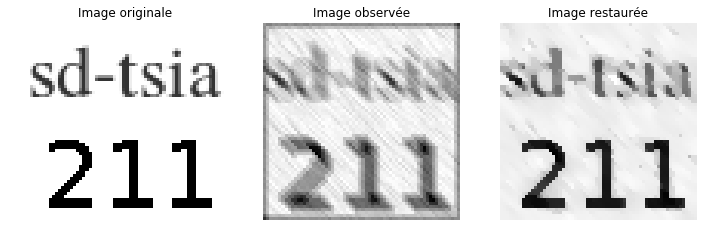

In [29]:
new=x_.reshape(64,64)
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.title("Image originale")
plt.imshow(original, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.title("Image observée")
plt.imshow(observations, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.title("Image restaurée")
plt.imshow(new, cmap='gray')
plt.axis('off')
plt.show()

### Manipulation 3

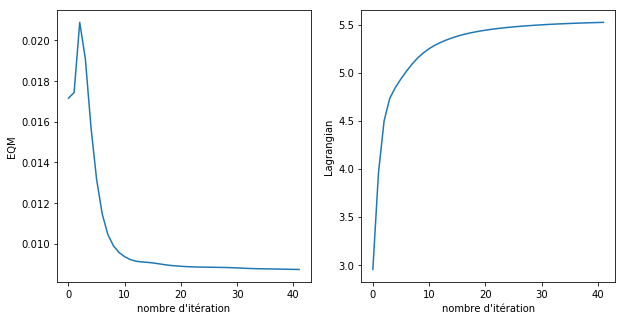

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(range(Iter),EQM)
plt.xlabel('nombre d\'itération')
plt.ylabel('EQM')
plt.subplot(122)
plt.plot(range(Iter),L)
plt.xlabel('nombre d\'itération')
plt.ylabel('Lagrangian')
plt.show()

On observe que EQM converge vers 0 après environ 20 itérations.

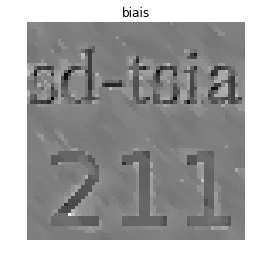

In [31]:
plt.imshow(original-new,cmap='gray')
plt.axis('off')
plt.title('biais')
plt.show()

### Manipulation 4

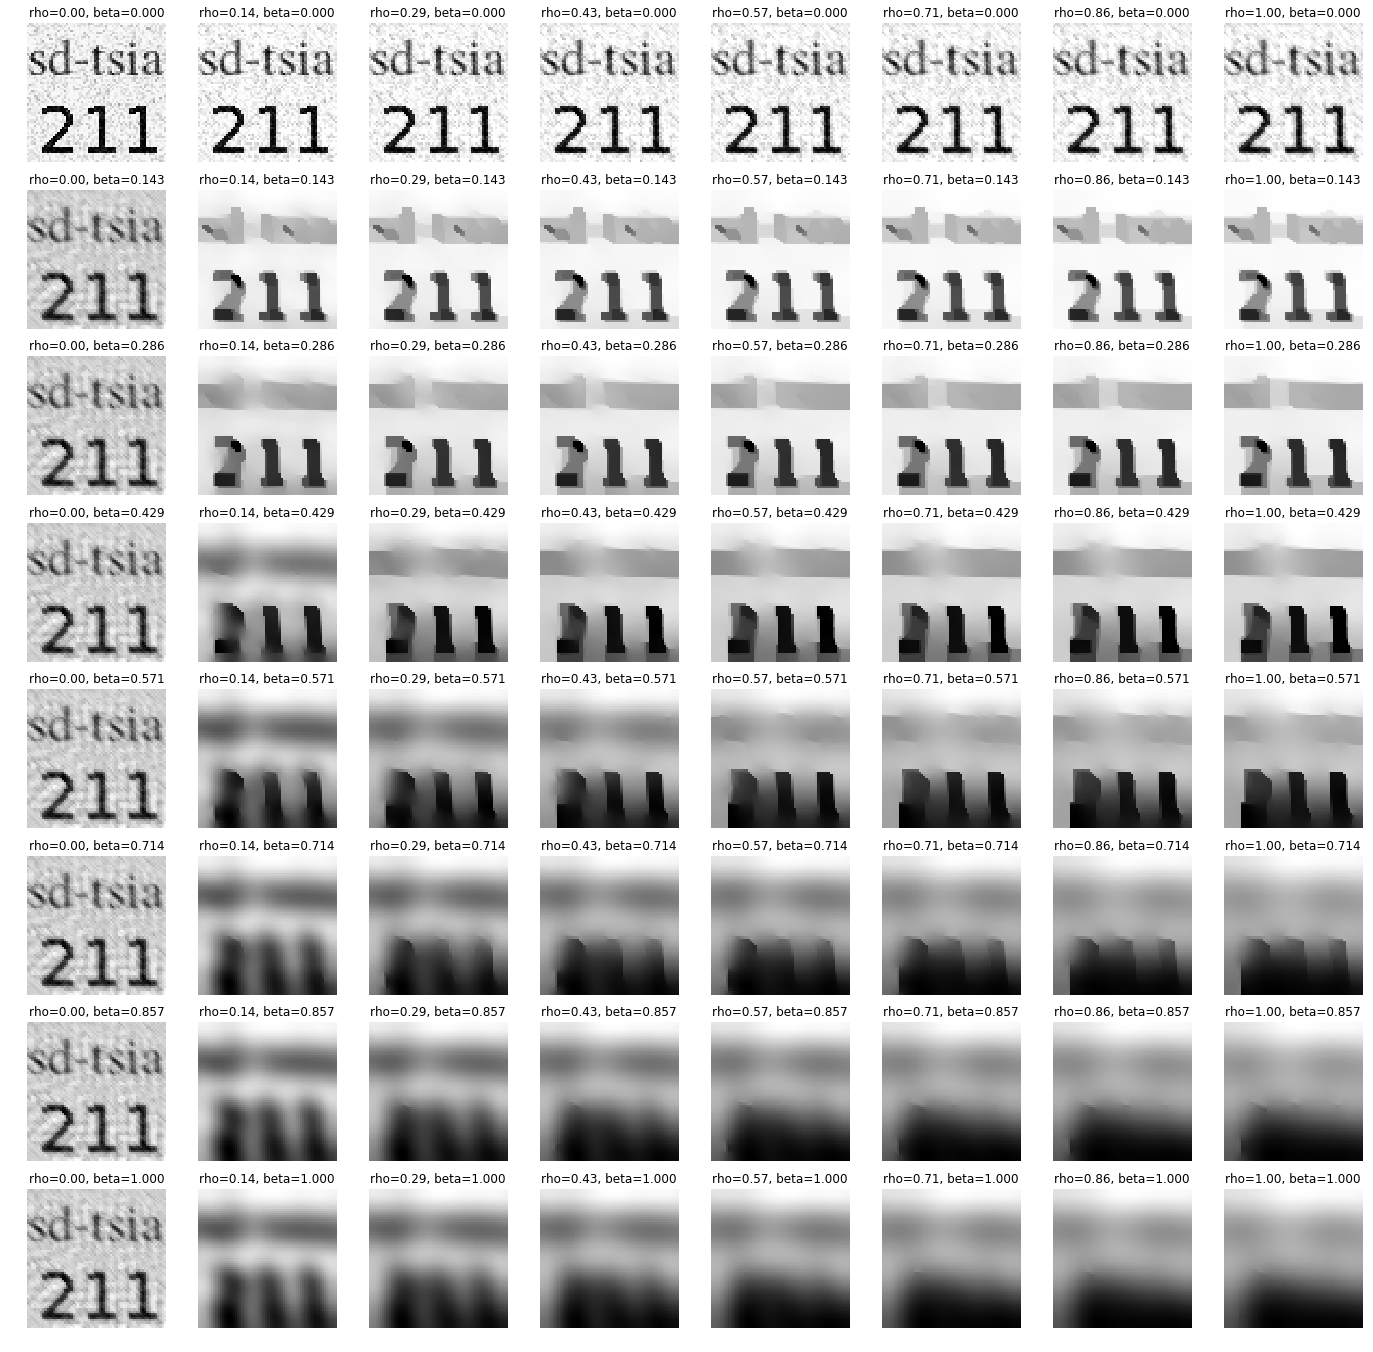

temps: 3662.602474


In [33]:
t0 = time.time()
num = 8
arr_rho = np.linspace(1e-4, 1, num)
arr_beta = np.linspace(1e-5, 1, num)
arr_rho, arr_beta = np.meshgrid(arr_rho, arr_beta)

arr_biais = np.empty_like(arr_rho, dtype=np.float32)
arr_EQM = np.empty_like(arr_rho, dtype=np.float32)
arr_L = np.empty_like(arr_rho, dtype=np.float32)
arr_k = np.empty_like(arr_rho, dtype=np.float32)
arr_Iter = np.empty_like(arr_rho, dtype=np.float32)
arr_bias = np.empty_like(arr_rho, dtype=np.float32)

plt.close('all')
plt.figure(num, figsize=(num*3, num*3))

for i in range(num):
    for j in range(num):
        x=np.zeros_like(y)
        z1 = x
        z2 = T.dot(x)
        gamma1 = np.zeros_like(z1)
        gamma2 = np.zeros_like(z2)
        rho = arr_rho[i][j]
        beta = arr_beta[i][j]
        x_restored, EQM, L, Iter = ADMM(x,y,y0,z1,z2,H,T,gamma1,gamma2,rho,beta,max_iter=k_max)
        arr_EQM[i][j] = EQM[-1]
        arr_L[i][j] = L[-1]
        arr_Iter[i][j] = Iter
        arr_bias[i][j] = np.sum(abs(x_restored - y0))
        plt.subplot(num, num, i*num+j+1)
        plt.title("rho=%0.2f, beta=%0.3f" % (rho, beta))
        plt.imshow(x_restored.reshape(64,64), cmap='gray')
        plt.axis('off')
plt.show()

print("temps: %f" %(time.time()-t0))

On peut voir que quand $\beta$ est grand, il y a moins de bruit dans l'image mais c'est plus flou, voire invisible. $\rho$ est le même cas.

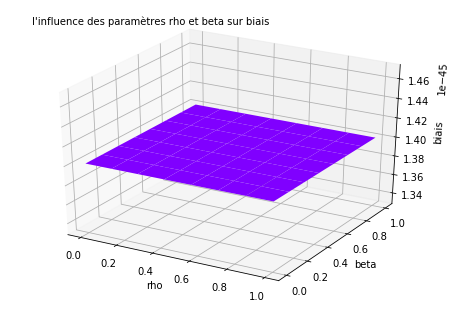

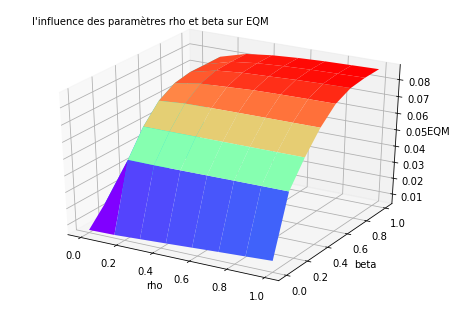

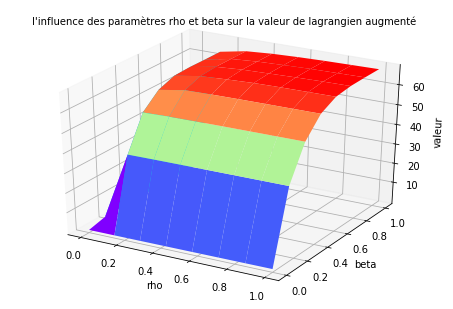

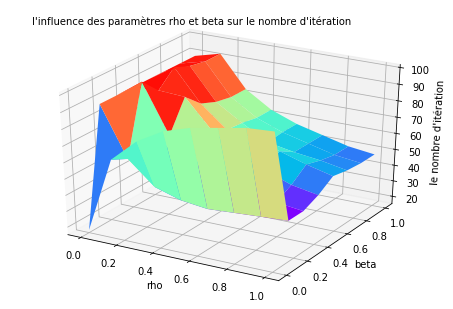

In [36]:
fig = plt.figure(1)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "l'influence des paramètres rho et beta sur biais", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_biais, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('biais')
plt.show()

fig = plt.figure(2)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "l'influence des paramètres rho et beta sur EQM", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_EQM, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('EQM')
plt.show()

fig = plt.figure(3)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "l'influence des paramètres rho et beta sur la valeur de lagrangien augmenté", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_L, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('valeur')
plt.show()

fig = plt.figure(4)
ax = Axes3D(fig)
ax.text2D(0.05, 0.95, "l'influence des paramètres rho et beta sur le nombre d'itération", transform=ax.transAxes)
ax.plot_surface(arr_rho, arr_beta, arr_Iter, cmap='rainbow')
ax.set_xlabel('rho')
ax.set_ylabel('beta')
ax.set_zlabel('le nombre d\'itération')
plt.show()

Le biais ne change pas beaucoup. EQM augmente avec $\beta$. La valeur de lagrangien augmenté augmente aussi avec $\beta$. Quand $\beta$ et $\rho$ sont grand, nombre d'iteration est petit.